# MIT AI for Code and Science workshop

In today's workshop we will learn

[list learning outcomes]

Domains help us restrict the search space of our problem. 

## CLEVR Domain

We will demonstrate the neurosymbolic paradigm using a recent dataset for [Compositional Language and Elementary Visual Reasoning](https://cs.stanford.edu/people/jcjohns/clevr/). The dataset contains visual scenes of objects with various attributes and relations. Each scene has an associated set of natural language question and answer pairs, e.g., 

> <img src='https://cs.stanford.edu/people/jcjohns/clevr/teaser.jpg'>
>
> Question: "*There is a sphere with the same size as the metal cube; is it made of the same material as the small red sphere?*"
>
> Answer: No (small red sphere is rubber material, whereas the sphere with the same size as the metal cube is metal material).



## Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/ucla/aishni-omar/

/content/drive/MyDrive/ucla/aishni-omar


In [9]:
import pandas as pd
import glob
import json
import ast
import itertools
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# read dataset

## Task: Visual Question and Answering (VQA)

Our goal is to find a program that can answer the question:

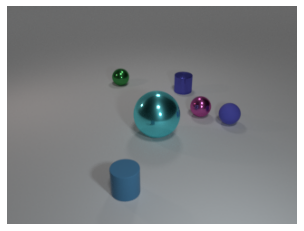

Question:  How big is the blue shiny sphere?
Answer:  large
Desired Program:  [{'inputs': [], 'function': 'scene', 'value_inputs': []}, {'inputs': [0], 'function': 'filter_color', 'value_inputs': ['blue']}, {'inputs': [1], 'function': 'filter_material', 'value_inputs': ['metal']}, {'inputs': [2], 'function': 'filter_shape', 'value_inputs': ['sphere']}, {'inputs': [3], 'function': 'unique', 'value_inputs': []}, {'inputs': [4], 'function': 'query_size', 'value_inputs': []}]


In [251]:
example_image = cv2.imread('datasets/clevr-dataset-gen-main/images/img5.png')
plt.imshow(example_image)
plt.axis("off")
plt.show()
example_question = "How big is the blue shiny sphere?"
print("Question: ", example_question)
example_program = [{'inputs': [], 'function': 'scene', 'value_inputs': []}, {'inputs': [0], 'function': 'filter_color', 'value_inputs': ['blue']},
 {'inputs': [1], 'function': 'filter_material', 'value_inputs': ['metal']},
 {'inputs': [2], 'function': 'filter_shape', 'value_inputs': ['sphere']},
 {'inputs': [3], 'function': 'unique', 'value_inputs': []},
 {'inputs': [4], 'function': 'query_size', 'value_inputs': []}]
example_answer = "large"
print("Answer: ", example_answer)
print("Desired Program: ", example_program) 

## Neural Representation

[Draft] Implement a neural network to solve the task. Pros: neural embeddings are an effective way to capture nuances about natural visual scenes, e.g. geometry, color, and shape.

In [ ]:
with open('/kaggle/input/clevr-dataset/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)

In [ ]:
#train_dataframe and val_dataframe stores the path to the images and respective questions and answers
train_length = 30000
val_length = 5000
trainList=[]
with open('/kaggle/input/clevr-dataset/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for K in range(train_length):
        i = data['questions'][K]
        temp=[]
        for path in glob.glob('/kaggle/input/clevr-dataset/CLEVR_v1.0/images/train/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        trainList.append(temp)
f.close()
labels=['Path','Question','Answer']
train_dataframe = pd.DataFrame.from_records(trainList, columns=labels)#training Dataframe 
del(data)
del(trainList)

valList=[]
with open('/kaggle/input/clevr-dataset/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    data = json.load(f)
    for k in range(val_length):
        i = data['questions'][k]
        temp=[]
        for path in glob.glob('/kaggle/input/clevr-dataset/CLEVR_v1.0/images/val/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        valList.append(temp)
f.close()
val_dataframe = pd.DataFrame.from_records(valList, columns=labels)#validation Dataframe
del(data)
del(valList)
val_dataframe.head()

In [59]:
# in progress
# what baseline did they use?
# https://www.kaggle.com/code/skloveyyp/vqacode

Failure Cases

In [44]:
# in progress

Run the cell below to inspect a neural embedding. You will notice that this representation is not interpretable. Has the network selected features that are truly relavant to the task?

In [45]:
# in progress

## Symbolic Representation

Reasoning with symbolic programs is interpretable.

### CLEVR Dataset Grammar

Questions in the CLEVR dataset can be represented as functional program. 

Programs are typically represented as a grammar. [define grammar].

Run the cell below to inspect the CLEVR dataset grammar. Here it is represented as a Python dictionary where each item is a (key, value) pair describing the functions in the grammar. Every function has a name, a set of inputs, side_inputs, output and boolean variable indicating whether the function is a terminal.

In [77]:
with open('datasets/clevr-dataset-gen-main/question_generation/metadata.json') as f:
    metadata = json.load(f)

functions_by_name = {}
for f in metadata['functions']:
  functions_by_name[f['name']] = f
metadata['_functions_by_name'] = functions_by_name
functions = metadata['_functions_by_name']
for k, v in functions.items():
  v.update({'type': 'function'})
types = metadata['types']

In [173]:
grammar = {k: {'name': k, 'values': v, 'inputs': None,  'outputs': None, 'terminal': None, 'type': 'primitive'} for k, v in types.items()}
grammar.update(functions)
grammar['Integer']['values'] = [i for i in range(11)]
grammar['Bool']['values'] = [True, False]
grammar

{'Object': {'name': 'Object',
  'values': None,
  'inputs': None,
  'outputs': None,
  'terminal': None,
  'type': 'primitive'},
 'ObjectSet': {'name': 'ObjectSet',
  'values': None,
  'inputs': None,
  'outputs': None,
  'terminal': None,
  'type': 'primitive'},
 'Integer': {'name': 'Integer',
  'values': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'inputs': None,
  'outputs': None,
  'terminal': None,
  'type': 'primitive'},
 'Bool': {'name': 'Bool',
  'values': [True, False],
  'inputs': None,
  'outputs': None,
  'terminal': None,
  'type': 'primitive'},
 'Shape': {'name': 'Shape',
  'values': ['cube', 'sphere', 'cylinder'],
  'inputs': None,
  'outputs': None,
  'terminal': None,
  'type': 'primitive'},
 'Color': {'name': 'Color',
  'values': ['gray',
   'red',
   'blue',
   'green',
   'brown',
   'purple',
   'cyan',
   'yellow'],
  'inputs': None,
  'outputs': None,
  'terminal': None,
  'type': 'primitive'},
 'Relation': {'name': 'Relation',
  'values': ['left', 'right', 'behind', '

In [21]:
with open('datasets/clevr-dataset-gen-main/question_generation/synonyms.json') as f:
    synonyms = json.load(f)

f.close()
synonyms

{'thing': ['thing', 'object'],
 'sphere': ['sphere', 'ball'],
 'cube': ['cube', 'block'],
 'large': ['large', 'big'],
 'small': ['small', 'tiny'],
 'metal': ['metallic', 'metal', 'shiny'],
 'rubber': ['rubber', 'matte'],
 'left': ['left of', 'to the left of', 'on the left side of'],
 'right': ['right of', 'to the right of', 'on the right side of'],
 'behind': ['behind'],
 'front': ['in front of'],
 'above': ['above'],
 'below': ['below']}

#### Symbolic Parsing

In [ ]:
def parse(question): # in progress
  example_template = {
    "params": [
      {"type": "Size", "name": "<Z>"},
      {"type": "Color", "name": "<C>"},
      {"type": "Material", "name": "<M>"},
      {"type": "Shape", "name": "<S>"},
      {"type": "Relation", "name": "<R>"},
      {"type": "Size", "name": "<Z2>"},
      {"type": "Color", "name": "<C2>"},
      {"type": "Material", "name": "<M2>"},
      {"type": "Shape", "name": "<S2>"}
    ],
    "text": [
      "How big is the <Z2> <C2> <M2> <S2> [that is] <R> the <Z> <C> <M> <S>?",
    ],
    "nodes": [
      {"type": "scene", "inputs": []},
      {"type": "filter_unique", "inputs": [0], "side_inputs": ["<Z>", "<C>", "<M>", "<S>"]},
      {"type": "relate_filter_unique", "inputs": [1], "side_inputs": ["<R>", "<Z2>", "<C2>", "<M2>", "<S2>"]},
      {"type": "query_size", "inputs": [2]}
    ],
    "constraints": [
      {"type": "NULL", "params": ["<Z2>"]}
    ]
  }
  parsed_params = {}
  for word, token in zip(question.split(), example_template['text'][0].split()):
    if token.startswith('<'):
      if word.endswith('?'):
        parsed_params[token] = word[:-1]
      else:
        parsed_params[token] = word
  #print(parsed_params)
  
  program = example_template['nodes']
  for p in program:
    if 'side_inputs' in p:
      inserted_values = [parsed_params[v] for v in p['side_inputs'] if v in parsed_params]
      p['side_inputs'] = inserted_values
  return program

def execute(program):
  # in progress
  pass

In [34]:
class CLEVR_OBJECT():
    def __init__(self):
      self.attribute = self.attribute = {  
        'size' : ["small", "large"],
        'color' : ["gray", "red", "blue", "green", "brown", "purple", "cyan", "yellow"],
        'shape' : ["cube", "sphere", "cylinder"],
        'material' : ["rubber", "metal"]
      }
      self.position
    def get_attr(self, x):
      return [k for k, v in self.attribute.items() if x in v][0]

class CLEVR_DSL():
  def __init__(self):
    self.obj = CLEVR_OBJECT()
    self.integer = [{str(i)} for i in range(11)]
    self.relation = ["left", "right", "behind", "front"]
    self.str2func = {'count': self.count}
  
  def query(self, obj, attr):
    i = obj.index[0]
    return obj[attr][i]

  def count(self, objects):
    return len(objects)
  
  #def relate(self, object, relation):

class ProgramExecutor(CLEVR_DSL):
  def __init__(self):
    super().__init__()
    pass
  
  def execute(self, function, params, output):
    output = self.str2func[function](output)
    return output

  def __call__(self, scene, program):
    self.scene = scene
    output = None
    for seq in program:
      args = seq.split()
      prev_out = self.execute(args[0], args[1], output)
    return output

**Cons:** Here we have 35 functions each taking 1 to 2 input parameters. In total we have 1024 possible permutations of parameters. Moreover, the functions can be composed to form larger programs, leading to a combinatorial explosion of the program space.

### Symbolic Search
One of the simplest class of search techniques is called enumeration which explictly constructions programs until we find one that satisfies the observations. As we saw before, the search space can become exponentially large. Thus, we need efficient ways to search in this space. 

There are two ways we can search for a program that satisfies this question: **top-down and bottom-up.**

#### Top-down Enumeration
Top-down enumeration starts by trying to discover a high-level structure of the program, and then enumerate the low-level fragments.

For instance, a program that represents the question, "How big is the brown shiny sphere?" will need to first instantiate the scene, filter objects by the color brown, by material (here shiny suggests metal), and by shape (sphere). As a result, a unique brown metal sphere object should remain in the set. Finally, the object can be queried for its size.

#### Bottom-up enumeration
In contrast, bottom-up search constructs all possible programs from a grammar starting with the terminals in the language.

For example, a program that represents the question, "How big is the brown shiny sphere?" will first try to assemble all terminal statements into possible functions to produce a program that is consistent with the question.

In [ ]:
def synthesize(grammar, question, answer): # bottom-up
  while(True):
    plist = grow(grammar)
    plist = elimEquivalents(plist, question)
    for p in plist:
      if(isCorrect(p, question, answer)):
        return p
    
def grow(grammar):
  terminals = {k: v for k, v in grammar.items() if v['terminal']}
  nonterminals = {k: v for k, v in grammar.items() if not (v['terminal'])}
  basetypes = {k: v for k, v in grammar.items() if v['type'] == 'primitive'}
  plist = []
  for n in nonterminals: 
    for t in terminals:
      if n in terminals[t]['inputs']:
        if basetypes[n]['values']: # Integer, Bool, Color, Material, Shape, Size
          if len(terminals[t]['inputs']) == 1:
            for v in basetypes[n]['values']:
              plist.append({'function': t, 'value_inputs': [v]})    
          else: # 2 arguments
            for v1, v2 in list(itertools.combinations(basetypes[n]['values'], 2)): # without replacement
              plist.append({'function': t, 'value_inputs': [v1, v2]})    
            for v in basetypes[n]['values']:
              plist.append({'function': t, 'value_inputs': [v, v]})    
        else: # Objectset and Object have no values
          if len(terminals[t]['inputs']) == 1:
            plist.append({'function': t, 'value_inputs': [n]})
          else: # 2 arguments
            plist.append({'function': t, 'value_inputs': [n, n]})
  return plist

def elimEquivalents(plist, question):
  """ 
  Observational Equivalence: any two expressions
  that produce the same outputs on the inputs 
  are deemed equivalent, regardless of whether 
  they are truly equivalent or not. All but one
  equivalent statements are eliminated.
  """
  return plist

def isCorrect(program, question, answer):
  p = parse(question)
  true_result = execute(p)
  predicted_result = execute(program)
  if result == answer:
    return True
  else:
    return False

In [246]:
print("There are ", len(grow(grammar)), " possible programs")

There are  255  possible programs


In [247]:
grow(grammar)

[{'function': 'query_shape', 'value_inputs': ['Object']},
 {'function': 'query_color', 'value_inputs': ['Object']},
 {'function': 'query_size', 'value_inputs': ['Object']},
 {'function': 'query_material', 'value_inputs': ['Object']},
 {'function': 'equal_object', 'value_inputs': ['Object', 'Object']},
 {'function': 'count', 'value_inputs': ['ObjectSet']},
 {'function': 'exist', 'value_inputs': ['ObjectSet']},
 {'function': 'filter_count', 'value_inputs': ['ObjectSet']},
 {'function': 'filter_exist', 'value_inputs': ['ObjectSet']},
 {'function': 'equal_integer', 'value_inputs': [0, 1]},
 {'function': 'equal_integer', 'value_inputs': [0, 2]},
 {'function': 'equal_integer', 'value_inputs': [0, 3]},
 {'function': 'equal_integer', 'value_inputs': [0, 4]},
 {'function': 'equal_integer', 'value_inputs': [0, 5]},
 {'function': 'equal_integer', 'value_inputs': [0, 6]},
 {'function': 'equal_integer', 'value_inputs': [0, 7]},
 {'function': 'equal_integer', 'value_inputs': [0, 8]},
 {'function': '

In [248]:
synthesize(grammar, example_question, example_answer)

{'function': 'query_shape', 'value_inputs': ['Object']}

### Learning to synthesize
add explaination and citations

## Neuro-symbolic Representation

We can combine neural and symbolic components to make more powerful representations. Why are they powerful? What are the ways they can be combined?

### NS-VQA Model
https://github.com/kexinyi/ns-vqa

In [3]:
%cd ns-vqa-master/

/content/drive/MyDrive/ucla/aishni-omar/ns-vqa-master


Install Anaconda

Install packages
*Instructions say NVIDIA GPU + CUDA 9.0 and PyTorch 0.3.1 or 0.4.0 required. We have CUDA 11.6 and PyTorch 0.3.1 is old version. Just installing the latest.*

In [4]:
!nvidia-smi

Sat Feb  4 01:49:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
%cd ns-vqa-master/
%ls

/content/drive/MyDrive/ucla/aishni-omar/ns-vqa-master
download.sh  mask_rcnn/   pretrained_model/  reason/           scene_parse/
img/         pretrained/  README.md          requirements.txt


In [21]:
# changed pytorch==0.4.0 to torch (latest)
# changed opencv to opencv-python
!pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/33/92/87e99adfaf9c847021ecfcd4bf2732c863752cf47c0c9ad349c8de260183/opencv-python-4.7.0.68.tar.gz
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-3ggth91l/opencv-python/


In [23]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


Download pretrained model.

In [24]:
%ls

download.sh  img/  README.md  reason/  requirements.txt  scene_parse/


In [25]:
!echo "Downloading pretrained model..."
!wget http://nsvqa.csail.mit.edu/assets/pretrained.zip
!unzip pretrained.zip
!rm pretrained.zip

!mkdir mask_rcnn
!cd mask_rcnn
!echo "Downloading pretrained weights for Mask R-CNN backbone..."
!wget http://nsvqa.csail.mit.edu/assets/backbones.zip
!unzip backbones.zip
!rm backbones.zip

!cd ..  # root

--2023-02-04 01:44:53--  http://nsvqa.csail.mit.edu/assets/pretrained.zip
Resolving nsvqa.csail.mit.edu (nsvqa.csail.mit.edu)... 128.52.131.62
Connecting to nsvqa.csail.mit.edu (nsvqa.csail.mit.edu)|128.52.131.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433659386 (414M) [application/zip]
Saving to: ‘pretrained.zip’

pretrained.zip      100%[===================>] 413.57M  35.9MB/s    in 12s     

2023-02-04 01:45:05 (34.8 MB/s) - ‘pretrained.zip’ saved [433659386/433659386]

Archive:  pretrained.zip
   creating: pretrained/
  inflating: pretrained/attribute_net.pt  
  inflating: pretrained/object_detector.pt  
  inflating: pretrained/question_parser.pt  
--2023-02-04 01:45:13--  http://nsvqa.csail.mit.edu/assets/backbones.zip
Resolving nsvqa.csail.mit.edu (nsvqa.csail.mit.edu)... 128.52.131.62
Connecting to nsvqa.csail.mit.edu (nsvqa.csail.mit.edu)|128.52.131.62|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485220185 (463M) [app

Compile CUDA code for Mask-RCNN

In [24]:
%cd /content/drive/MyDrive/ucla/aishni-omar/ns-vqa-master/scene_parse/mask_rcnn/lib

/content/drive/MyDrive/ucla/aishni-omar/ns-vqa-master/scene_parse/mask_rcnn/lib


In [14]:
!pip install torch

In [25]:
!sh make.sh

running build_ext
building 'utils.cython_bbox' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/utils
gcc -pthread -B /usr/local/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/usr/local/lib/python3.6/site-packages/numpy/core/include -I/usr/local/include/python3.6m -c utils/cython_bbox.c -o build/temp.linux-x86_64-3.6/utils/cython_bbox.o -Wno-cpp
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/utils
gcc -pthread -shared -B /usr/local/compiler_compat -L/usr/local/lib -Wl,-rpath=/usr/local/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/utils/cython_bbox.o -o build/lib.linux-x86_64-3.6/utils/cython_bbox.cpython-36m-x86_64-linux-gnu.so
building 'utils.cython_nms' extension
gcc -pthread -B /usr/local/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/usr/local/lib/python3.6/site-packages

# skipping above step

In [27]:
%cd /content/drive/MyDrive/ucla/aishni-omar/ns-vqa-master/reason
%ls
# clevr-train
!python tools/preprocess_questions.py \
    --input_questions_json ../datasets/CLEVR_sample/questions/CLEVR_train_questions.json \
    --output_h5_file ../results/nsvqa/reason/clevr_h5/clevr_train_questions.h5 \
    --output_vocab_json ../results/nsvqa/clevr_h5/clevr_vocab.json

# clevr-val
!python tools/preprocess_questions.py \
    --input_questions_json ../datasets/CLEVR_sample/questions/CLEVR_val_questions.json \
    --output_h5_file ../results/nsvqa/reason/clevr_h5/clevr_val_questions.h5 \
    --input_vocab_json ../results/nsvqa/reason/clevr_h5/clevr_vocab.json

/content/drive/MyDrive/ucla/aishni-omar/ns-vqa-master/reason
datasets/  executors/  models/  options/  tools/  trainer.py  utils/
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Traceback (most recent call last):
  File "tools/preprocess_questions.py", line 11, in <module>
    import utils.programs as program_utils
ModuleNotFoundError: No module named 'utils'
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Traceback (most recent call last):
  File "tools/preprocess_questions.py", lin

In [50]:
# in progress
# implement neurosymbolic concept learner
# https://arxiv.org/pdf/1904.12584.pdf

(02/03/2023 - 7pm, makes sense to switch to python script instead of colab)

(reproduce results by writing these functions on your own)

Neural Parsing with GPT Codex (Question --> Program)

# Conclusion

# Further Reading

### References

[1] Johnson, Justin, et al. "Clevr: A diagnostic dataset for compositional language and elementary visual reasoning." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017. ([Github](https://github.com/facebookresearch/clevr-dataset-gen/tree/main/question_generation), [Website](https://cs.stanford.edu/people/jcjohns/clevr/))

[2] Solar-Lezama. "6.S981 Introduction to Program Synthesis Fall 2022." ([Website](https://people.csail.mit.edu/asolar/SynthesisCourse/index.htm)) 

[3] Mao, Jiayuan, et al. "The Neuro-Symbolic Concept Learner: Interpreting Scenes, Words, and Sentences From Natural Supervision." International Conference on Learning Representations. ([Github](https://github.com/vacancy/NSCL-PyTorch-Release), [Website](https://openreview.net/pdf?id=rJgMlhRctm))

